In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr as pearsonr

In [2]:
import gemmi
from gemmi import cif

In [3]:
from iotbx.data_manager import DataManager

Set up your working directory and executable paths

In [4]:

PATH_main = '/home/mkadukova/data/refinement_playground_clean/'
PATH_gemmi_exe = '/home/mkadukova/soft/gemmi/build/gemmi'
CMD_ccp4_source = 'source ~/soft/xtal/ccp4-7.1/include/ccp4.setup-sh.in'
CMD_mtz2map = 'python3 ~/soft/miniconda3/pkgs/cctbx-base-2021.8-py38hf7c6b08_0/lib/python3.8/site-packages/mmtbx/command_line/mtz2map.py'


try:
    os.mkdir(PATH_main)
except FileExistsError:
    pass

os.chdir(PATH_main)


In [5]:
# Two pdbcodes for choice

pdbcode = '10gs'
# pdbcode = '101m'

# grid_sizes from fft for uniform output (I precompuded them below and put here)
exact_sizes_ = {'10gs': (144, 168, 130),
                '101m': (180, 180, 96)}
exact_size_ = exact_sizes_[pdbcode]

try:
    os.mkdir('{0}{1}'.format(PATH_main, pdbcode))
except FileExistsError:
    pass

os.chdir('{0}{1}'.format(PATH_main, pdbcode))
os.system('curl https://files.rcsb.org/download/{0}.pdb -o {1}{2}/{2}.pdb'.format(pdbcode.upper(), PATH_main, pdbcode))
os.system('curl https://files.rcsb.org/download/{0}.cif -o {1}{2}/{2}.cif'.format(pdbcode.upper(), PATH_main, pdbcode))
os.system('curl https://edmaps.rcsb.org/coefficients/{0}.mtz -o {1}{0}/{0}.mtz'.format(pdbcode, PATH_main))
os.chdir(PATH_main)

patt_com = '{0}{1}/{1}.{2}'.format(PATH_main, pdbcode, '{0}')
path_com = '{0}{1}/{1}.pdb'.format(PATH_main, pdbcode)
path_com_mtz = '{0}{1}/{1}.mtz'.format(PATH_main, pdbcode)
path_com_wfofc_ccp4 = '{0}{1}/{1}.wfofc.ccp4'.format(PATH_main, pdbcode)
path_com_2fofc_ccp4 = '{0}{1}/{1}.2fofc.ccp4'.format(PATH_main, pdbcode)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  318k    0  318k    0     0   225k      0 --:--:--  0:00:01 --:--:--  226k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  368k    0  368k    0     0   241k      0 --:--:--  0:00:01 --:--:--  241k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1472k    0 1472k    0     0   408k      0 --:--:--  0:00:03 --:--:--  409k


In [6]:
os.system("""{0};mtzfix hklin {1} hklout {2} << eof-1
end
eof-1""".format(CMD_ccp4_source,
                patt_com.format('mtz'),
                patt_com.format('fixed.mtz'),
                ))


MTZFIX  Version: 27-Apr-19


Checks performed by this program (A=acentric, C=centric):

A1:  FC = 2m.Fo - FM
A2:  FC >= 2m.Fo - FM
A3:  FD = FM - m.Fo
A4:  FD = 2(FM - m.Fo)

C5:  FC = 2m.Fo - FM
C6:  FM = m.Fo
C7:  FD = m.Fo - FC
C8:  FD = 2(m.Fo - FC)
C9:  FD <= m.Fo - FC

10:  FM = FC for unobserved
11:  FD = 0 for unobserved

where Fo = Fobs
      m  = FOM
      FC = D*Fcalc (Fcalc corrected for parameter errors),
      FM = 'minimally biased' Fourier coefficient,
      FD = 'minimally biased' difference Fourier coefficient,
      FM & FD are corrected for phase difference from phi(calc).

<B><FONT COLOR="#FF0000"><!--SUMMARY_BEGIN-->
<html> <!-- CCP4 HTML LOGFILE -->
<hr>
<!--SUMMARY_END--></FONT></B>

 OPENED INPUT MTZ FILE 
 Logical Name: HKLIN   Filename: /home/mkadukova/data/refinement_playground_clean/10gs/10gs.mtz 

 * Title:

   Output mtz file from refmac

 * Base dataset:

        0 HKL_base
          HKL_base
          HKL_base

 * Number of Datasets = 1

 * Dataset ID,

0

 mtzfix:  Normal termination.
Times: User:       0.2s System:    0.0s Elapsed:     0:00  
</pre>
</html>
<!--SUMMARY_END--></FONT></B>


### Functions for map generation

In [7]:
def pdb_mtz_2_ccp4(pdbin, mtzin, oname, fcol='FC', phcol='PHIC', ret=False,
                  margin=5, grid_sample_rate=3, exact_size=None,
                  do_extent=False, verbose=False):
    """
    reads pdb and mtz, saves map to a ccp4
    we only need the pdb for a correctly computed box & symmetries
    """
    st = None
    mtz = gemmi.read_mtz_file(mtzin)
    if verbose:
        print(list(mtz.column_labels()))
    if exact_size is not None:
        grid = mtz.transform_f_phi_to_map(fcol, phcol, sample_rate=grid_sample_rate,
                                         exact_size=exact_size)
    else:
        grid = mtz.transform_f_phi_to_map(fcol, phcol, sample_rate=grid_sample_rate)
    ccp4_map = gemmi.Ccp4Map()
    ccp4_map.grid = grid
    ccp4_map.update_ccp4_header()
    if do_extent:
        st = gemmi.read_structure(pdbin)
        ccp4_map.set_extent(st.calculate_fractional_box(margin=margin))
        ccp4_map.update_ccp4_header()
    ccp4_map.write_ccp4_map(oname)
    if ret:
        return st, mtz, grid, ccp4_map

In [8]:
def run_gemmisfcalc(hklin, mapout, fcol, phcol, exact_size=None, pdb_file=None):
    os.system('{0} sf2map \
           -f {3} -p {4}{5} {1} {2}'.format(
        PATH_gemmi_exe,
        hklin,
        mapout,
        fcol, phcol,
        ' --grid={0},{1},{2} --exact'.format(*exact_size) if exact_size is not None else ''
    ))

In [9]:
def run_fft_simple(hklin, mapout, fcol, phcol):
    os.system("""{0};fft hklin {1} mapout {2} << eof-1
        LABIN F1={3} PHI={4}
        GRID SAMP 4
        END
        eof-1""".format(CMD_ccp4_source,
                        hklin,
                        mapout,
                        fcol, phcol
                        ))

In [10]:
def run_mtz2map(mtz_file, prefix_out, fcol, phcol, exact_size=None, pdb_file=None):
    os.system('{0} \
              --mtz_file={1} --labels={2},{3} --output.prefix={4}.cctbx{5}{6}'.format(  # 
        CMD_mtz2map,
        mtz_file,
        fcol,
        phcol,
        prefix_out,
        ' --gridding={0},{1},{2}'.format(*exact_size) if exact_size is not None else '',
        ' --pdb_file={0}'.format(pdb_file) if pdb_file is not None else ''
             )
             )


### Compare maps written with gemmi, mmtbx's mtz2map, and fft

In [11]:
pdb_mtz_2_ccp4(pdbin=path_com, 
               mtzin=patt_com.format('mtz'),
               oname=patt_com.format('wfofc.ccp4'), 
               fcol='DELFWT', phcol='PHDELWT',
               ret=False, 
               margin=0, grid_sample_rate=4,
               exact_size=exact_size_, 
               verbose=False)

pdb_mtz_2_ccp4(pdbin=path_com, 
               mtzin=patt_com.format('fixed.mtz'),
               oname=patt_com.format('fixed.wfofc.ccp4'), 
               fcol='DELFWT', phcol='PHDELWT',
               ret=False, 
               margin=0, grid_sample_rate=4,
               exact_size=exact_size_, 
               verbose=False)

# g = gemmi.read_ccp4_map(patt_com.format('wfofc.ccp4')).grid
# print(g.nu, g.nv, g.nw)
# print(gemmi.read_ccp4_map(patt_com.format('wfofc.ccp4')).axis_positions())

In [12]:
run_gemmisfcalc(
    patt_com.format('mtz'),
    patt_com.format('gemmitool.wfofc.map'),
    'DELFWT',
    'PHDELWT',
    exact_size_,
)
run_gemmisfcalc(
    patt_com.format('fixed.mtz'),
    patt_com.format('fixed.gemmitool.wfofc.map'),
    'DELFWT',
    'PHDELWT',
    exact_size_,
)

In [13]:
run_fft_simple(patt_com.format('mtz'),
               patt_com.format('fft.wfofc.map'),
               'DELFWT',
               'PHDELWT'
               )
run_fft_simple(patt_com.format('fixed.mtz'),
               patt_com.format('fixed.fft.wfofc.map'),
               'DELFWT',
               'PHDELWT'
               )

# get the grid size to use it with other map generating scripts
g = gemmi.read_ccp4_map(patt_com.format('fft.wfofc.map')).grid
print(g.nu, g.nv, g.nw)
print(gemmi.read_ccp4_map(patt_com.format('fft.wfofc.map')).axis_positions())

sh: line 4: warning: here-document at line 0 delimited by end-of-file (wanted `eof-1')


<B><FONT COLOR="#FF0000"><!--SUMMARY_BEGIN-->
<html> <!-- CCP4 HTML LOGFILE -->
<hr>
<!--SUMMARY_END--></FONT></B>
<B><FONT COLOR="#FF0000"><!--SUMMARY_BEGIN-->
<pre>
 
 ###############################################################
 ###############################################################
 ###############################################################
 ### CCP4 7.1.016: FFTBIG           version 7.1.016 :         ##
 ###############################################################
 User: mkadukova  Run date: 19/10/2021 Run time: 15:44:16 


 Please reference: Collaborative Computational Project, Number 4. 2011.
 "Overview of the CCP4 suite and current developments". Acta Cryst. D67, 235-242.
 as well as any specific reference in the program write-up.

<!--SUMMARY_END--></FONT></B>
 Data line---         LABIN F1=DELFWT PHI=PHDELWT
 Data line---         GRID SAMP 4
 Data line---         END

 OPENED INPUT MTZ FILE 
 Logical Name: HKLIN   Filename: /home/mkadukova/data/refinement_

sh: line 4: warning: here-document at line 0 delimited by end-of-file (wanted `eof-1')


  Section Y = 143 minimum rho =        -0.3337 at X =  93 Z =   2 maximum rho =         0.4529 at X =  88 Z = 115
  Section Y = 144 minimum rho =        -0.3486 at X = 110 Z =   1 maximum rho =         0.3479 at X = 107 Z =   7
  Section Y = 145 minimum rho =        -0.3010 at X =  17 Z = 118 maximum rho =         0.4107 at X =  21 Z =  76
  Section Y = 146 minimum rho =        -0.3116 at X =  25 Z =  37 maximum rho =         0.4224 at X = 128 Z =  49
  Section Y = 147 minimum rho =        -0.3126 at X =  49 Z =  15 maximum rho =         0.4856 at X = 128 Z =  49
  Section Y = 148 minimum rho =        -0.3265 at X =  44 Z =   4 maximum rho =         0.4026 at X =  16 Z =  80
  Section Y = 149 minimum rho =        -0.3696 at X =  44 Z =   4 maximum rho =         0.4188 at X =  47 Z = 110
  Section Y = 150 minimum rho =        -0.3602 at X =  32 Z =  40 maximum rho =         0.4116 at X =  48 Z =  84
  Section Y = 151 minimum rho =        -0.3558 at X =  24 Z =  16 maximum rho =         

In [14]:
run_mtz2map(patt_com.format('mtz'),
            pdbcode + '/' + pdbcode,
           'DELFWT', 'PHDELWT',
            exact_size=exact_size_)
run_mtz2map(patt_com.format('fixed.mtz'),
            pdbcode + '/' + pdbcode + '.fixed',
           'DELFWT', 'PHDELWT',
            exact_size=exact_size_)

No model input - will output map(s) in unit cell.
Processing map: DELFWT,PHDELWT
  applying sigma-scaling
  wrote /tmp_mnt/filer1/unix/mkadukova/data/refinement_playground_clean/10gs/10gs.cctbx_mFo-DFc.ccp4
No model input - will output map(s) in unit cell.
Processing map: DELFWT,PHDELWT
  applying sigma-scaling
  wrote /tmp_mnt/filer1/unix/mkadukova/data/refinement_playground_clean/10gs/10gs.fixed.cctbx_mFo-DFc.ccp4


In [17]:
check_fixed = True
ks = [
      'gemmi',
      'cctbx',
      'gemmitool',
      'fft'
      ]
    
map_path_tails = {
        'gemmi': 'wfofc.ccp4',
        'cctbx': 'cctbx_mFo-DFc.ccp4',
        'gemmitool': 'gemmitool.wfofc.map',
        'fft': 'fft.wfofc.map',
       }
    
if check_fixed:
    for k in ks:
        map_path_tails[k + '.fixed'] = 'fixed.' + map_path_tails[k]
    ks = ks + [k + '.fixed' for k in ks]

maps, dims, grid_data = {}, {}, {}

for k_ in ks:
    maps[k_] = gemmi.read_ccp4_map(patt_com.format(map_path_tails[k_]))
    dims[k_] = maps[k_].grid.nu, maps[k_].grid.nv, maps[k_].grid.nw
    grid_data[k_] = np.array(maps[k_].grid)
    grid_data[k_] = grid_data[k_].transpose(maps[k_].axis_positions())
    dims[k_] = grid_data[k_].shape

Cctbx std is always normalized. But gemmi's and fft's isn't.\
Here we can see that gemmi's and fft's std is the same for the initial file, and are not the same for the mtzfixed file.

In [18]:
for k in ks:
    print("{0} {1} {2} {3}".format(k, dims[k], 
                                  grid_data[k].shape, 
                                  np.std(grid_data[k])),
         )

gemmi (144, 168, 130) (144, 168, 130) 0.09444427490234375
cctbx (144, 168, 130) (144, 168, 130) 1.0000001192092896
gemmitool (144, 168, 130) (144, 168, 130) 0.09444427490234375
fft (144, 168, 130) (144, 168, 130) 0.09444427490234375
gemmi.fixed (144, 168, 130) (144, 168, 130) 0.06720957159996033
cctbx.fixed (144, 168, 130) (144, 168, 130) 0.9999998807907104
gemmitool.fixed (144, 168, 130) (144, 168, 130) 0.06720957159996033
fft.fixed (144, 168, 130) (144, 168, 130) 0.09339244663715363


Correlation coefficients are all the same for the initial mtz file:

In [19]:
print(pearsonr(grid_data['gemmi'].flatten(), grid_data['fft'].flatten()))
print(pearsonr(grid_data['gemmitool'].flatten(), grid_data['cctbx'].flatten()))
print(pearsonr(grid_data['fft'].flatten(), grid_data['cctbx'].flatten()))


(0.9999999999962053, 0.0)
(0.9999999999999807, 0.0)
(0.999999999996205, 0.0)


But not for gemmi-converted map created from the mtzfixed mtz file!

In [20]:
print(pearsonr(grid_data['gemmi.fixed'].flatten(), grid_data['fft.fixed'].flatten()))
print(pearsonr(grid_data['gemmitool.fixed'].flatten(), grid_data['cctbx.fixed'].flatten()))
print(pearsonr(grid_data['fft.fixed'].flatten(), grid_data['cctbx.fixed'].flatten()))
print(pearsonr(grid_data['cctbx'].flatten(), grid_data['cctbx.fixed'].flatten()))
print(pearsonr(grid_data['gemmi'].flatten(), grid_data['gemmi.fixed'].flatten()))


(0.7196467646221824, 0.0)
(0.7196467646238007, 0.0)
(0.999999999996193, 0.0)
(0.9963295095294274, 0.0)
(0.7188274337733871, 0.0)


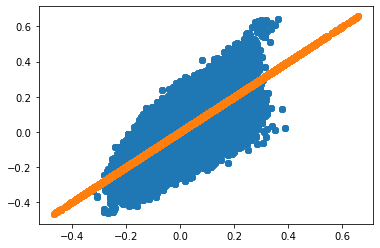

In [21]:
%matplotlib inline

plt.scatter(grid_data['gemmi.fixed'].flatten(), grid_data['fft.fixed'].flatten())
plt.scatter(grid_data['gemmi'].flatten(), grid_data['fft'].flatten())

Why?

Let's check the MTZ files content with mtzdump, cctbx, and gemmi.\
I took the DELFWT,PHDELWT columns

1) read the reflection data with gemmi:

In [22]:
mtz0 = gemmi.read_mtz_file(patt_com.format('mtz'))
mtz1 = gemmi.read_mtz_file(patt_com.format('fixed.mtz'))
print([(i, l) for i, l in enumerate(mtz0.column_labels())])
hkl1 = np.array(mtz1)[:, :3]
d0_gemmi = np.array(mtz0)[:, 12]
d1_gemmi = np.array(mtz1)[:, 12]
dp0_gemmi = np.array(mtz0)[:, 13]
dp1_gemmi = np.array(mtz1)[:, 13]
print(d0_gemmi.shape, d1_gemmi.shape)

[(0, 'H'), (1, 'K'), (2, 'L'), (3, 'FREE'), (4, 'FP'), (5, 'SIGFP'), (6, 'FC'), (7, 'PHIC'), (8, 'FC_ALL'), (9, 'PHIC_ALL'), (10, 'FWT'), (11, 'PHWT'), (12, 'DELFWT'), (13, 'PHDELWT'), (14, 'FOM'), (15, 'FC_ALL_LS'), (16, 'PHIC_ALL_LS')]
(22104,) (22104,)


2) read the reflection data with cctbx:

In [23]:
dm0 = DataManager()
dm1 = DataManager()
dm0.process_miller_array_file(patt_com.format('mtz'))
dm1.process_miller_array_file(patt_com.format('fixed.mtz'))
reflections_reader0 = dm0.get_miller_array(filename=patt_com.format('mtz'))
reflections_reader1 = dm1.get_miller_array(filename=patt_com.format('fixed.mtz'))
miller_array_dict0 = {ma.info().label_string():ma for ma in reflections_reader0.as_miller_arrays()}
miller_array_dict1 = {ma.info().label_string():ma for ma in reflections_reader1.as_miller_arrays()}

In [24]:
d0_cctbx = np.array(miller_array_dict0['DELFWT,PHDELWT'].amplitudes().data())
d1_cctbx = np.array(miller_array_dict1['DELFWT,PHDELWT'].amplitudes().data())
dp0_cctbx = np.array(miller_array_dict0['DELFWT,PHDELWT'].phases().data())
dp1_cctbx = np.array(miller_array_dict1['DELFWT,PHDELWT'].phases().data())

Now, compare what's different.

First, cctbx:

Text(0, 0.5, 'amplitudes in mtzfixed, cctbx')

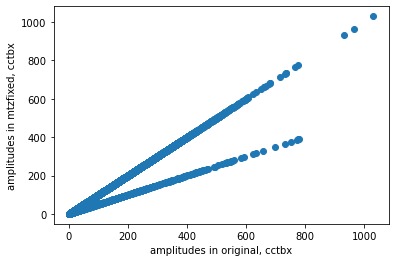

In [25]:
plt.scatter(d0_cctbx, d1_cctbx)
plt.xlabel('amplitudes in original, cctbx')
plt.ylabel('amplitudes in mtzfixed, cctbx')

Text(0, 0.5, 'phases in mtzfixed, cctbx')

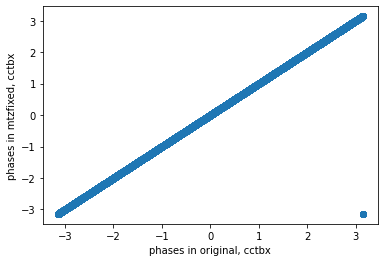

In [26]:
plt.scatter(dp0_cctbx, dp1_cctbx)
plt.xlabel('phases in original, cctbx')
plt.ylabel('phases in mtzfixed, cctbx')

And now, gemmi:

amplitudes:

Text(0, 0.5, 'amplitudes in mtzfixed, gemmi')

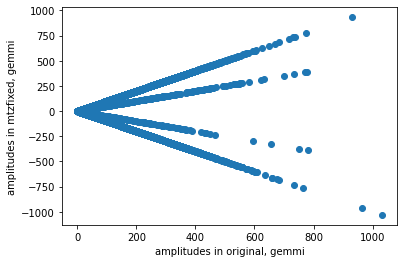

In [27]:
plt.scatter(d0_gemmi, d1_gemmi)
plt.xlabel('amplitudes in original, gemmi')
plt.ylabel('amplitudes in mtzfixed, gemmi')

Text(0, 0.5, 'amplitudes in mtzfixed, gemmi')

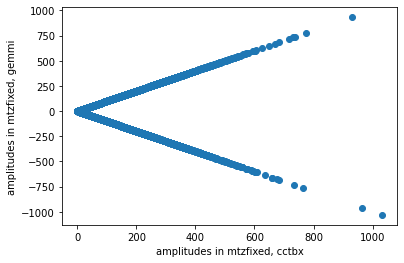

In [28]:
plt.scatter(d1_cctbx, d1_gemmi)
plt.xlabel('amplitudes in mtzfixed, cctbx')
plt.ylabel('amplitudes in mtzfixed, gemmi')

What we can actually see here, is that in gemmi there are some negative amplitudes.\
After taking the absolute value we get the 1:1 correspondence.

Text(0, 0.5, 'np.abs(amplitudes in mtzfixed), gemmi')

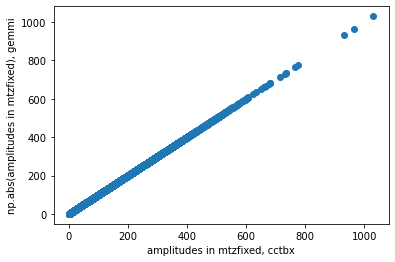

In [29]:
plt.scatter(d1_cctbx, np.abs(d1_gemmi))
plt.xlabel('amplitudes in mtzfixed, cctbx')
plt.ylabel('np.abs(amplitudes in mtzfixed), gemmi')

Now, phases -- the difference is quite substantial even if we forget about the angle conversion.

Text(0, 0.5, 'phases in mtzfixed, gemmi')

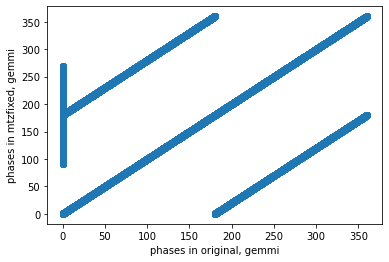

In [30]:
plt.scatter(dp0_gemmi, dp1_gemmi)
plt.xlabel('phases in original, gemmi')
plt.ylabel('phases in mtzfixed, gemmi')

With angle conversion

Text(0, 0.5, 'phases in mtzfixed, gemmi in radians')

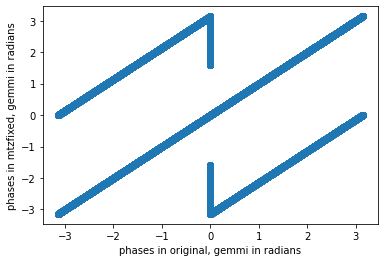

In [31]:
dp0_gemmi_c = dp0_gemmi * np.pi/ 180.
dp1_gemmi_c = dp1_gemmi * np.pi/ 180.
dp0_gemmi_c[np.where(dp0_gemmi_c > np.pi)] = (dp0_gemmi_c[np.where(dp0_gemmi_c > np.pi)] - np.pi*2)
dp1_gemmi_c[np.where(dp1_gemmi_c > np.pi)] = (dp1_gemmi_c[np.where(dp1_gemmi_c > np.pi)] - np.pi*2)
plt.scatter(dp0_gemmi_c, dp1_gemmi_c)
plt.xlabel('phases in original, gemmi in radians')
plt.ylabel('phases in mtzfixed, gemmi in radians')

What's the difference between the mtz files themselves?

Let's run

`mtzdump hklin 101m.mtz`

`mtzdump hklin 101m.fixed.mtz`

and check the output for the first negative amplitude value.

In [32]:
hkl1[np.where(d1_gemmi < 0)[0]]

array([[-36.,   0.,   5.],
       [-36.,   2.,   4.],
       [-36.,   4.,   3.],
       ...,
       [ 34.,   8.,   4.],
       [ 35.,   3.,   1.],
       [ 35.,   5.,   0.]], dtype=float32)

```mtzdump hklin 101m.mtz
START 0 0 10
GO
```

```mtzdump hklin 101m.fixed.mtz
START 0 0 10
GO
```

show 

```
    0   0  10        1.00    583.44      0.03    518.01    130.60    585.68
                   132.09    532.91    132.09     52.78    312.09      0.96
                   608.49    132.18
```
and 
```
    0   0  10        1.00    583.44      0.03    518.01    130.60    585.68
                   132.09    532.91    132.09    -52.78    132.09      0.96
                   608.49    132.18
```
The phase here, in the negative amplitude point, is changed by pi!

So let's change it as well. And also set the zero amplitude points' phases to zero to get rid of the appearing vertical bar.

Text(0, 0.5, 'phases in mtzfixed, gemmi in radians\n with phase shift corrected')

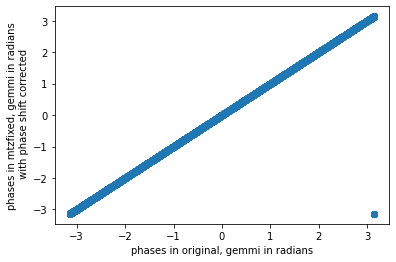

In [34]:
dp0_gemmi_c = dp0_gemmi * np.pi/ 180.
dp1_gemmi_c = dp1_gemmi * np.pi/ 180.
dp0_gemmi_c[np.where(dp0_gemmi_c > np.pi)] = (dp0_gemmi_c[np.where(dp0_gemmi_c > np.pi)] - np.pi*2)

dp1_gemmi_c[np.where(d1_gemmi < 0)] = (dp1_gemmi_c[np.where(d1_gemmi < 0)] - np.pi)


dp1_gemmi_c[np.where(dp1_gemmi_c > np.pi)] = (dp1_gemmi_c[np.where(dp1_gemmi_c > np.pi)] - np.pi*2)
dp1_gemmi_c[np.where(d1_gemmi == 0)] = 0
plt.scatter(dp0_gemmi_c, dp1_gemmi_c)
plt.xlabel('phases in original, gemmi in radians')
plt.ylabel('phases in mtzfixed, gemmi in radians\n with phase shift corrected')


cctbx and gemmi are now the same for the mtzfixed output

Text(0, 0.5, 'phases in mtzfixed, gemmi in radians\n with phase shift corrected')

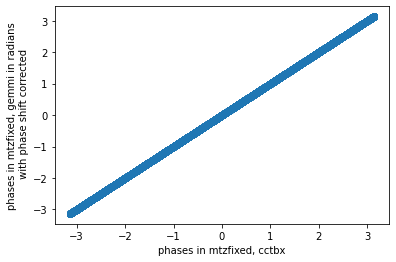

In [35]:
plt.scatter(dp1_cctbx, dp1_gemmi_c)
plt.xlabel('phases in mtzfixed, cctbx')
plt.ylabel('phases in mtzfixed, gemmi in radians\n with phase shift corrected')


If we now add this conversion to gemmi function in a dirty way with exact column indexes:

In [36]:
def pdb_mtz_2_ccp4(pdbin, mtzin, oname, fcol='FC', phcol='PHIC', ret=False,
                  margin=5, grid_sample_rate=3, exact_size=None,
                  do_extent=False, verbose=False):
    """
    reads pdb and mtz, saves map to a ccp4
    we only need the pdb for a correctly computed box & symmetries
    """
    st = None
    mtz = gemmi.read_mtz_file(mtzin)
    
    # here:
    arr = np.array(mtz, copy=False)
    d1 = arr[:, 12]
    dp1 = arr[:, 13]
    dp1[np.where(d1 < 0)] = (dp1[np.where(d1 < 0)] - 180)
    dp1[np.where(d1 == 0)] = 0
    arr[:, 13] = dp1
    arr[:, 12] = np.abs(arr[:, 12])
    
    if verbose:
        print(list(mtz.column_labels()))
    if exact_size is not None:
        grid = mtz.transform_f_phi_to_map(fcol, phcol, sample_rate=grid_sample_rate,
                                         exact_size=exact_size)
    else:
        grid = mtz.transform_f_phi_to_map(fcol, phcol, sample_rate=grid_sample_rate)
    ccp4_map = gemmi.Ccp4Map()
    ccp4_map.grid = grid
    ccp4_map.update_ccp4_header()
    if do_extent:
        st = gemmi.read_structure(pdbin)
        ccp4_map.set_extent(st.calculate_fractional_box(margin=margin))
        ccp4_map.update_ccp4_header()
    ccp4_map.write_ccp4_map(oname)
    if ret:
        return st, mtz, grid, ccp4_map

In [37]:
pdb_mtz_2_ccp4(pdbin=path_com, 
               mtzin=patt_com.format('mtz'),
               oname=patt_com.format('after.wfofc.ccp4'), 
               fcol='DELFWT', phcol='PHDELWT',
               ret=False, 
               margin=0, grid_sample_rate=4,
               exact_size=exact_size_, 
               verbose=False)

pdb_mtz_2_ccp4(pdbin=path_com, 
               mtzin=patt_com.format('fixed.mtz'),
               oname=patt_com.format('fixed.after.wfofc.ccp4'), 
               fcol='DELFWT', phcol='PHDELWT',
               ret=False, 
               margin=0, grid_sample_rate=4,
               exact_size=exact_size_, 
               verbose=False)

In [38]:
check_fixed = True
ks_after = [
      'gemmi.after',
      'gemmi.fixed.after'
      ]
    
map_path_tails['gemmi.after'] = 'after.wfofc.ccp4'
map_path_tails['gemmi.fixed.after'] = 'fixed.after.wfofc.ccp4'

for k_ in ks_after:
    maps[k_] = gemmi.read_ccp4_map(patt_com.format(map_path_tails[k_]))
    dims[k_] = maps[k_].grid.nu, maps[k_].grid.nv, maps[k_].grid.nw
    grid_data[k_] = np.array(maps[k_].grid)
    grid_data[k_] = grid_data[k_].transpose(maps[k_].axis_positions())
    dims[k_] = grid_data[k_].shape

In [39]:
for k in ks + ks_after:
    print("{0} {1} {2} {3}".format(k, dims[k], 
                                  grid_data[k].shape, 
                                  np.std(grid_data[k])),
         )

gemmi (144, 168, 130) (144, 168, 130) 0.09444427490234375
cctbx (144, 168, 130) (144, 168, 130) 1.0000001192092896
gemmitool (144, 168, 130) (144, 168, 130) 0.09444427490234375
fft (144, 168, 130) (144, 168, 130) 0.09444427490234375
gemmi.fixed (144, 168, 130) (144, 168, 130) 0.06720957159996033
cctbx.fixed (144, 168, 130) (144, 168, 130) 0.9999998807907104
gemmitool.fixed (144, 168, 130) (144, 168, 130) 0.06720957159996033
fft.fixed (144, 168, 130) (144, 168, 130) 0.09339244663715363
gemmi.after (144, 168, 130) (144, 168, 130) 0.09444427490234375
gemmi.fixed.after (144, 168, 130) (144, 168, 130) 0.09339247643947601


Problem solved:

In [40]:
print(pearsonr(grid_data['gemmi'].flatten(), grid_data['fft'].flatten()))
print(pearsonr(grid_data['gemmi.after'].flatten(), grid_data['cctbx'].flatten()))
print(pearsonr(grid_data['gemmi.fixed'].flatten(), grid_data['fft.fixed'].flatten()))
print(pearsonr(grid_data['gemmi.fixed.after'].flatten(), grid_data['fft.fixed'].flatten()))

(0.9999999999962053, 0.0)
(0.9999999999999807, 0.0)
(0.7196467646221824, 0.0)
(0.9999999999961778, 0.0)


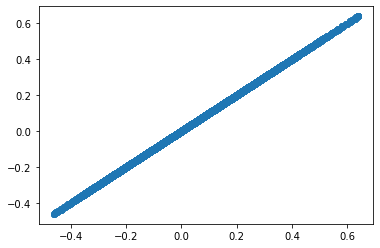

In [41]:
plt.scatter(grid_data['gemmi.fixed.after'].flatten(), grid_data['fft.fixed'].flatten())